In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from scipy.stats import skew
import os
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s4e8/train.csv", index_col = "id", engine="pyarrow")
test = pd.read_csv("/kaggle/input/playground-series-s4e8/test.csv", index_col = "id", engine="pyarrow")

print(train.shape)
print(test.shape)

(3116945, 21)
(2077964, 20)


In [4]:
sub=pd.read_csv("/kaggle/input/playground-series-s4e8/sample_submission.csv")

In [5]:
train.tail(5)

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,
3116940,e,9.29,f,None,n,t,None,None,w,12.14,...,b,None,w,u,w,t,g,None,d,u
3116941,e,10.88,s,None,w,t,d,c,p,6.65,...,None,None,w,None,None,f,f,None,d,u
3116942,p,7.82,x,e,e,f,a,None,w,9.51,...,None,None,y,None,w,t,z,None,d,a
3116943,e,9.45,p,i,n,t,e,None,p,9.13,...,None,y,w,None,None,t,p,None,d,u
3116944,p,3.20,x,s,g,f,d,c,w,2.82,...,None,None,w,None,None,f,f,None,g,u


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3116945 entries, 0 to 3116944
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), object(18)
memory usage: 523.2+ MB


In [7]:
train.isnull().sum()

class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64

In [8]:
test.isnull().sum()

cap-diameter                  7
cap-shape                    31
cap-surface              446904
cap-color                    13
does-bruise-or-bleed         10
gill-attachment          349821
gill-spacing             839595
gill-color                   49
stem-height                   1
stem-width                    0
stem-root               1838012
stem-surface            1321488
stem-color                   21
veil-type               1971545
veil-color              1826124
has-ring                     19
ring-type                 86195
spore-print-color       1899617
habitat                      25
season                        0
dtype: int64

In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
cap-diameter,3116941.0,6.309848,4.657931,0.03,3.32,5.75,8.24,80.67
stem-height,3116945.0,6.348333,2.699755,0.00,4.67,5.88,7.41,88.72
stem-width,3116945.0,11.153785,8.095477,0.00,4.97,9.65,15.63,102.90


In [10]:
train.describe(include="O")

,class,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
count,3116945,3116905,2445922,3116933,3116937,2593009,1858510,3116888,359922,1136084,3116907,159452,375998,3116921,2988065,267263,3116900,3116945
unique,2,74,83,78,26,78,48,63,38,60,59,22,24,23,40,32,52,4
top,p,x,t,n,f,a,c,w,b,s,w,u,w,f,f,k,d,a
freq,1705396,1436026,460777,1359542,2569743,646034,1331054,931538,165801,327610,1196637,159373,279070,2368820,2477170,107310,2177573,1543321


class
p    1705396
e    1411549
Name: count, dtype: int64


<Axes: ylabel='count'>

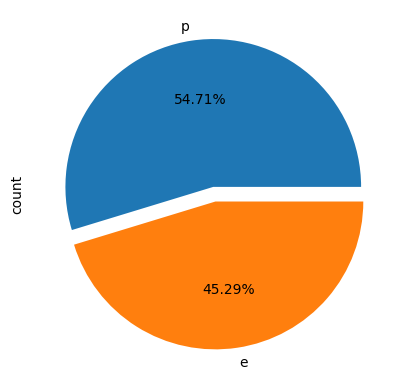

In [11]:
value_count = train["class"].value_counts()
print(value_count)
train["class"].value_counts().plot(kind='pie', labels=value_count.index, y='Percent_of_each_class', autopct='%1.2f%%', explode=(0.05, 0.05))

**EDA of Numerical & Categorical columns**

In [12]:
le = LabelEncoder()
train['class'] = le.fit_transform(train['class'])

In [13]:
X = train.drop(columns=['class'], axis=1)
y = train['class']
X.tail(5)

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,
3116940,9.29,f,None,n,t,None,None,w,12.14,18.81,b,None,w,u,w,t,g,None,d,u
3116941,10.88,s,None,w,t,d,c,p,6.65,26.97,None,None,w,None,None,f,f,None,d,u
3116942,7.82,x,e,e,f,a,None,w,9.51,11.06,None,None,y,None,w,t,z,None,d,a
3116943,9.45,p,i,n,t,e,None,p,9.13,17.77,None,y,w,None,None,t,p,None,d,u
3116944,3.20,x,s,g,f,d,c,w,2.82,7.79,None,None,w,None,None,f,f,None,g,u


In [14]:
num_cols = ['cap-diameter', 'stem-height','stem-width']
cat_cols = [i for i in X.columns if X[i].dtype == 'object']
print(cat_cols)

['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']


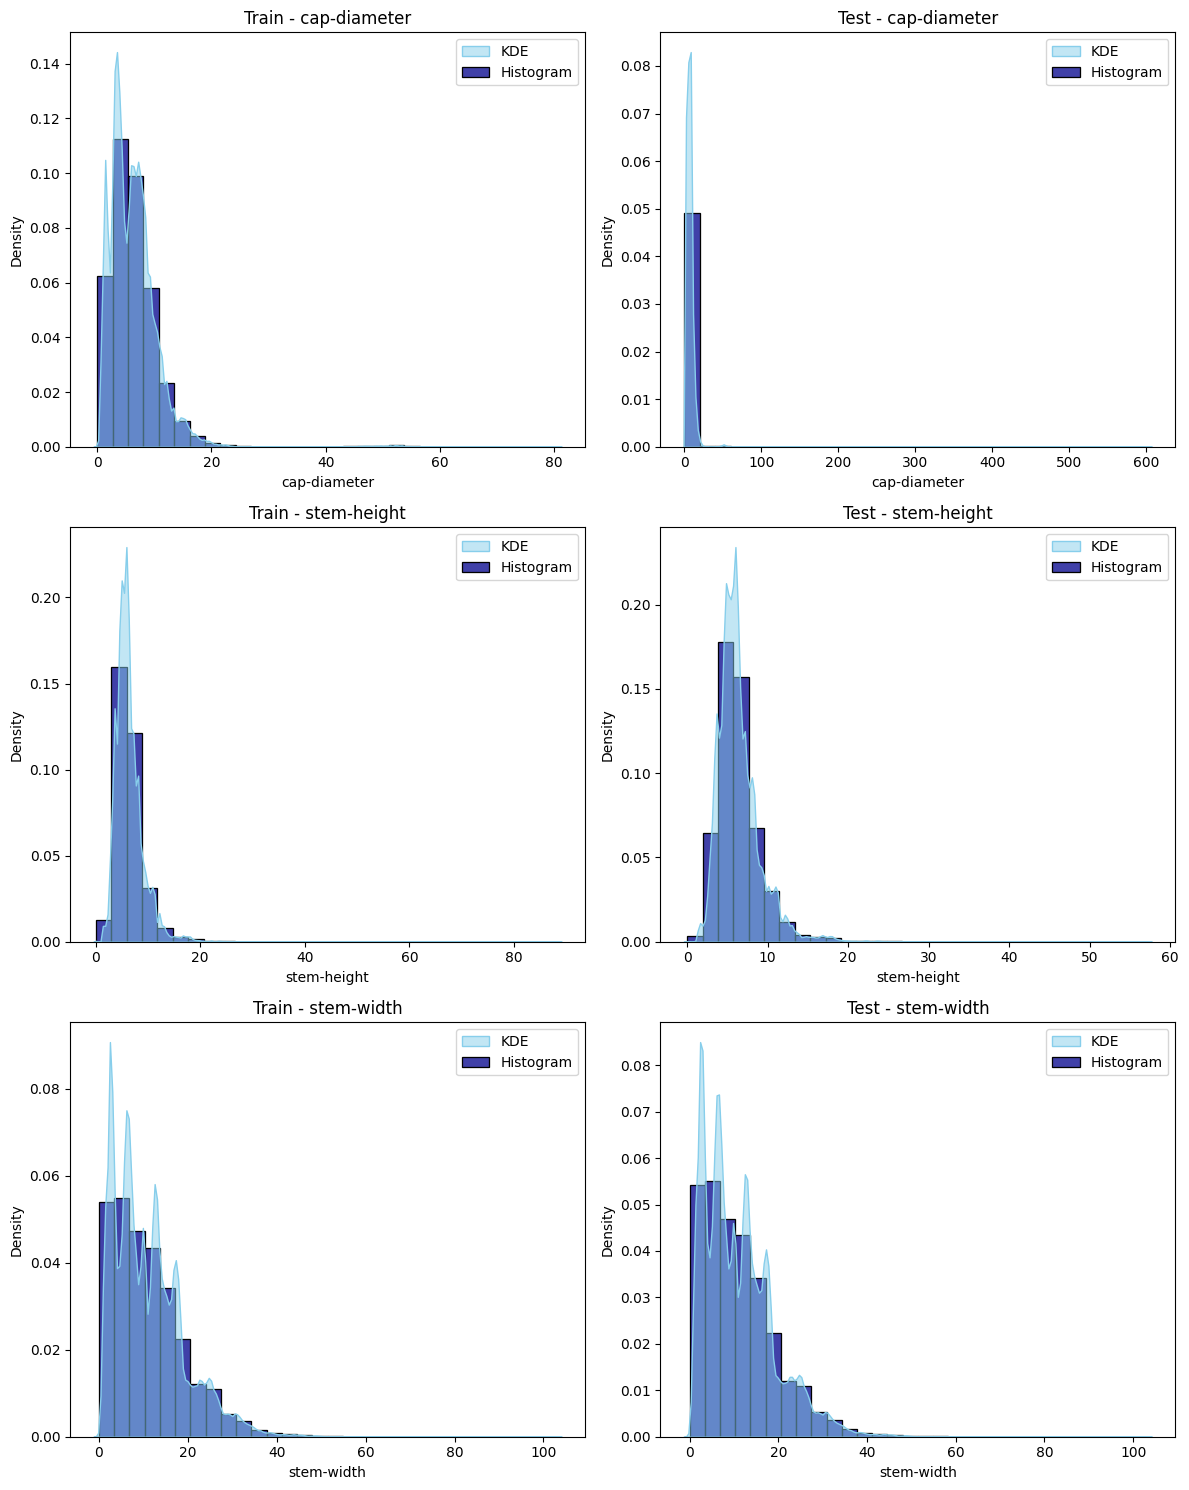

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))  # Adjust figsize as needed
axes = axes.flatten()
for i, feature in enumerate(num_cols):
    # Training data
    sns.histplot(train[feature], bins=30, kde=False, color='darkblue', label='Histogram', stat='density', ax=axes[i*2])
    sns.kdeplot(train[feature], color='skyblue', label='KDE', fill=True, alpha=0.5, ax=axes[i*2])
    axes[i*2].set_title(f'Train - {feature}')
    axes[i*2].set_xlabel(feature)
    axes[i*2].set_ylabel('Density')
    axes[i*2].legend()

    # Test data
    sns.histplot(test[feature], bins=30, kde=False, color='darkblue', label='Histogram', stat='density', ax=axes[i*2 + 1])
    sns.kdeplot(test[feature], color='skyblue', label='KDE', fill=True, alpha=0.5, ax=axes[i*2 + 1])
    axes[i*2 + 1].set_title(f'Test - {feature}')
    axes[i*2 + 1].set_xlabel(feature)
    axes[i*2 + 1].set_ylabel('Density')
    axes[i*2 + 1].legend()

plt.tight_layout()
plt.show()

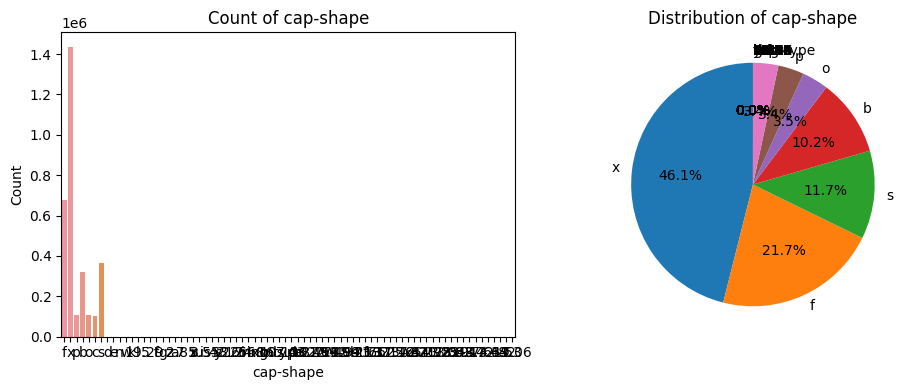

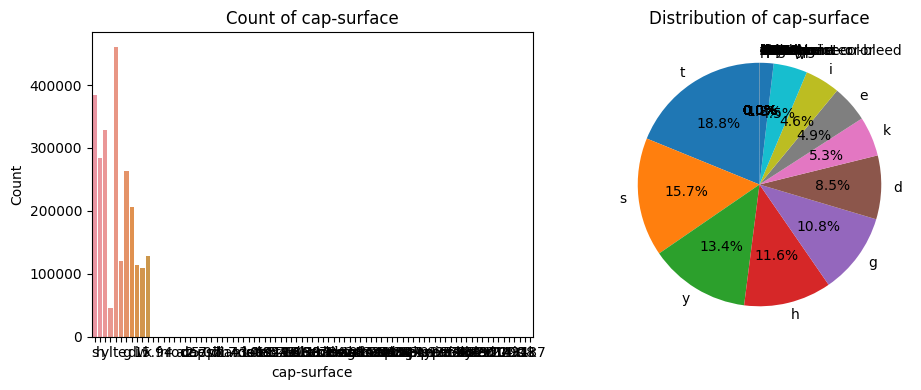

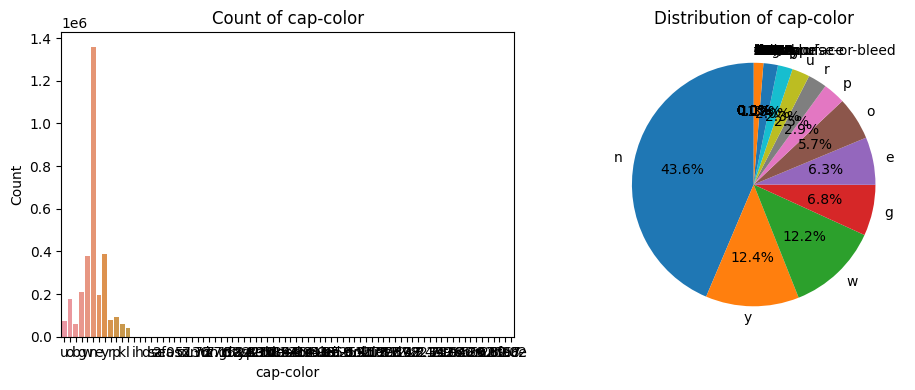

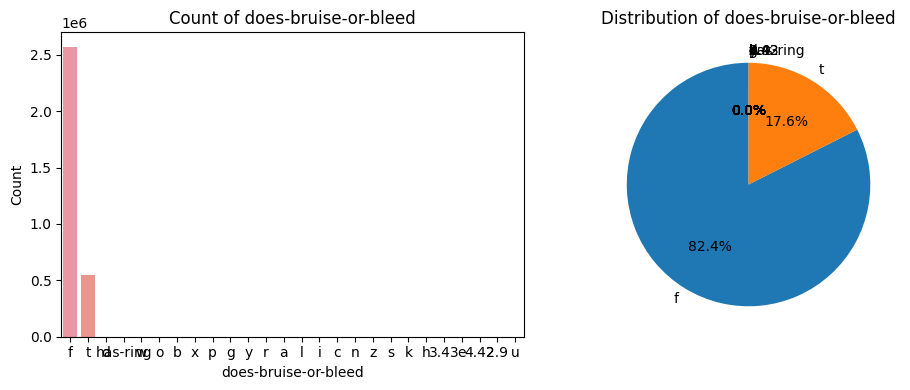

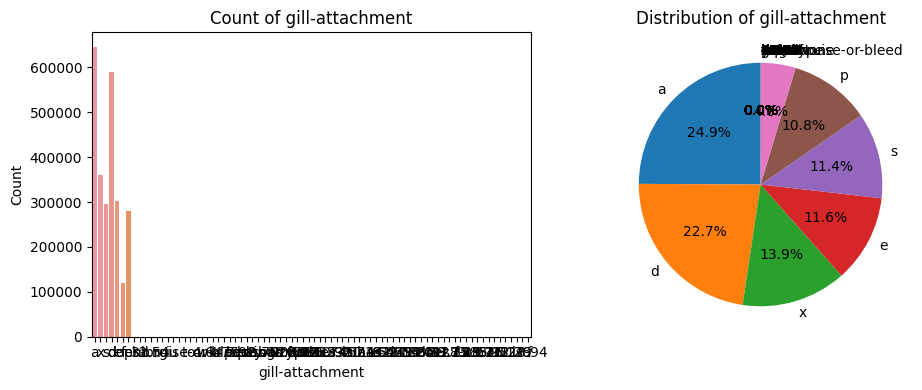

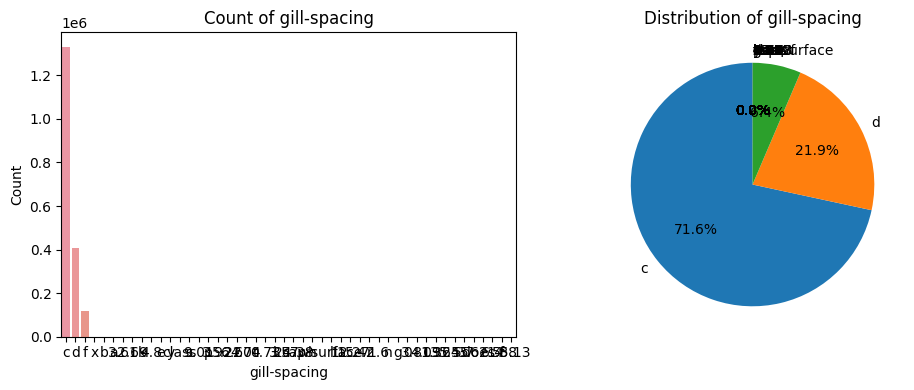

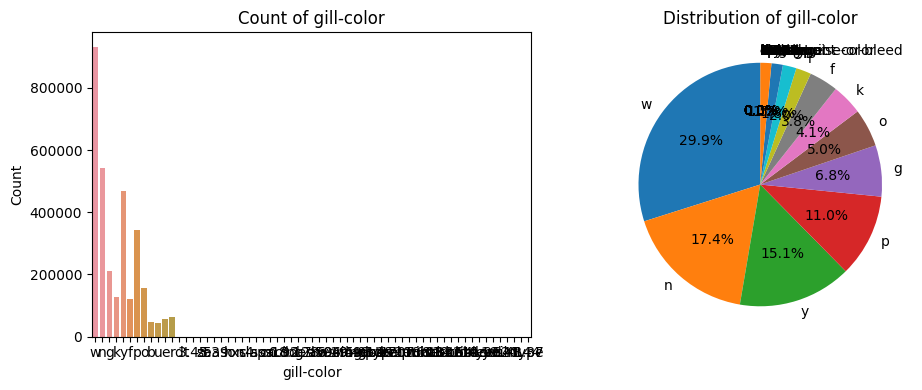

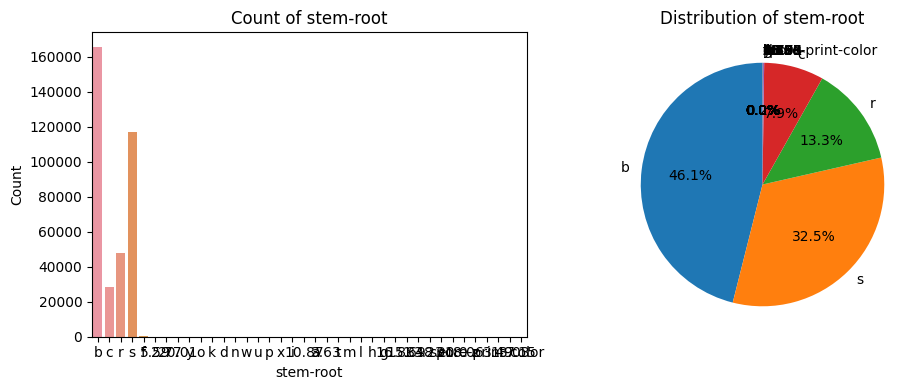

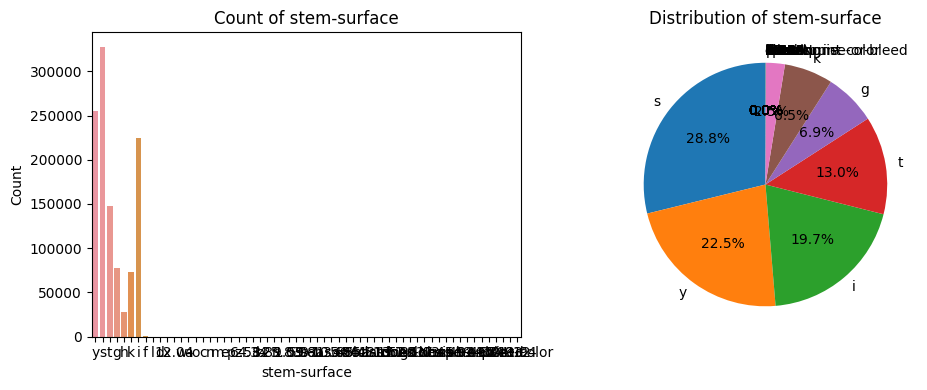

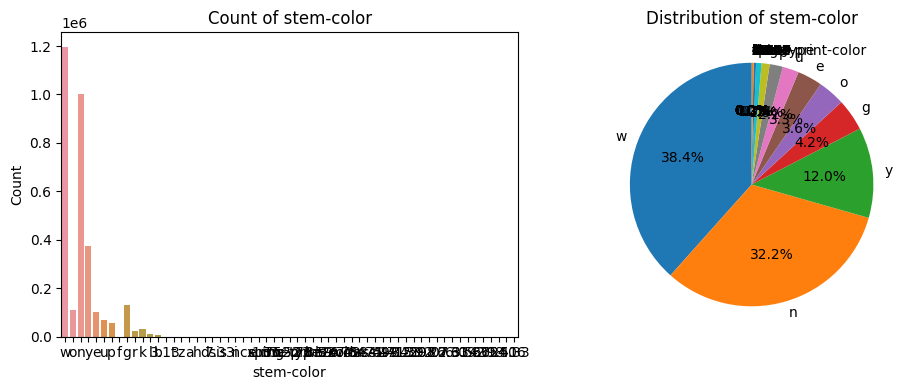

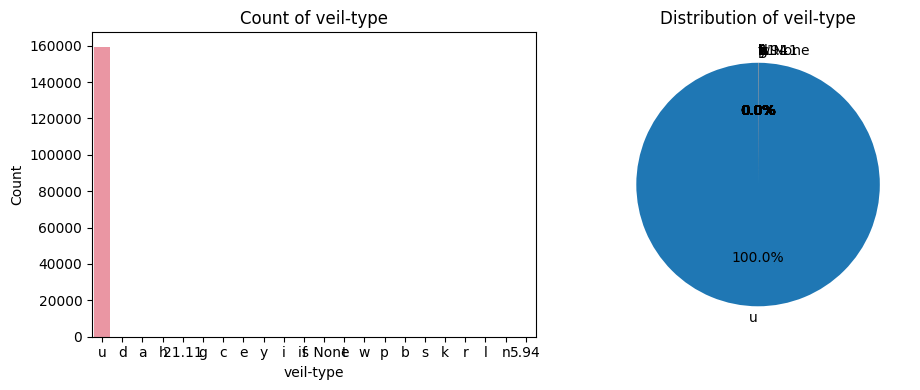

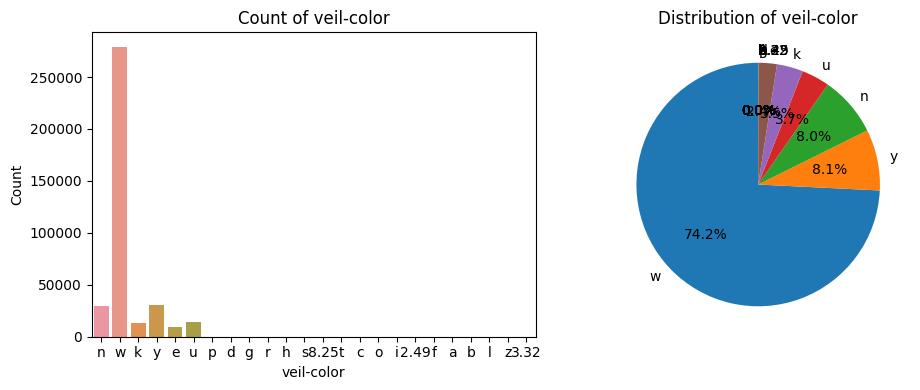

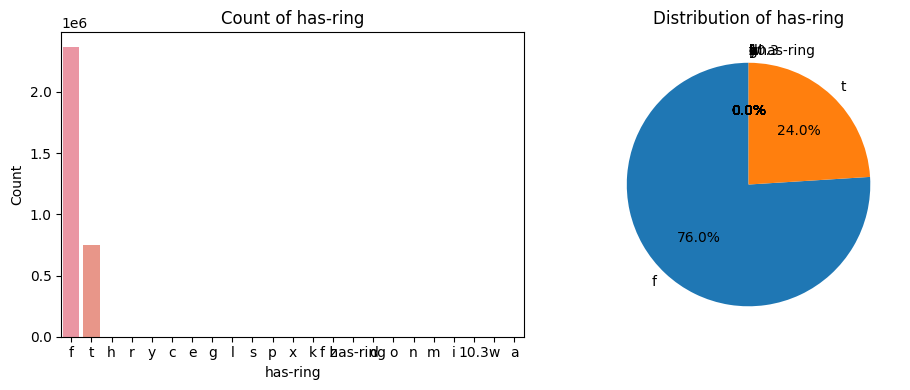

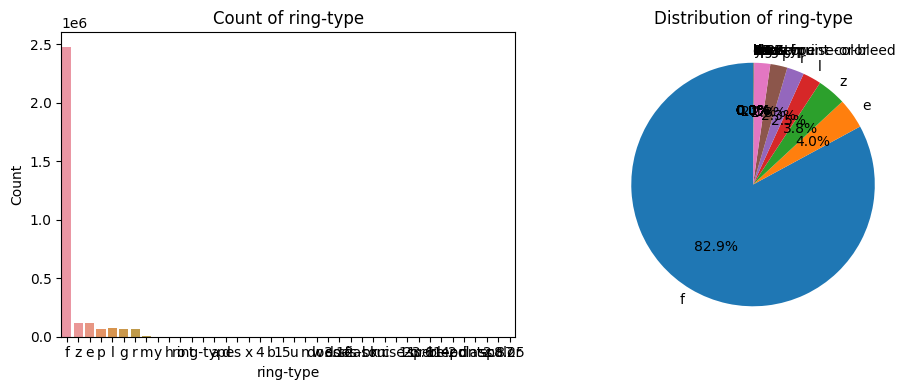

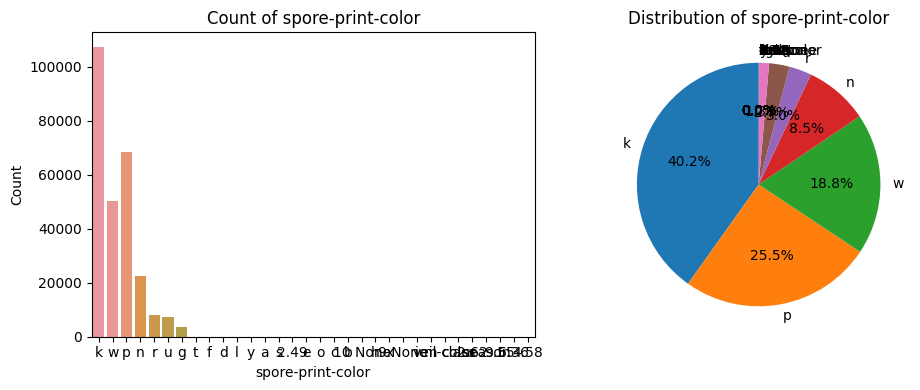

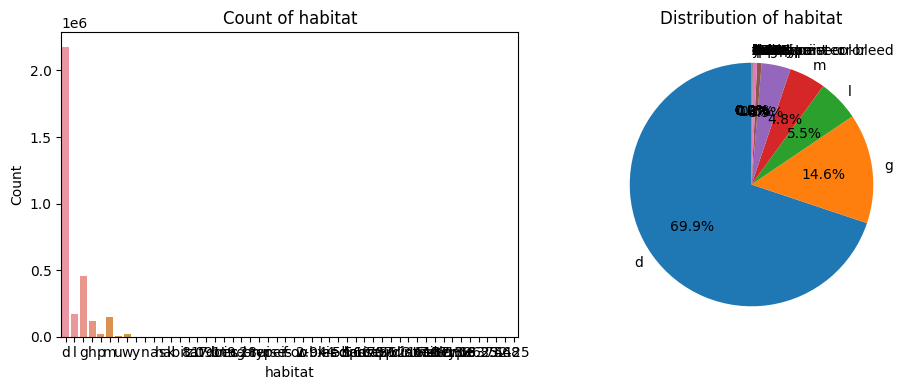

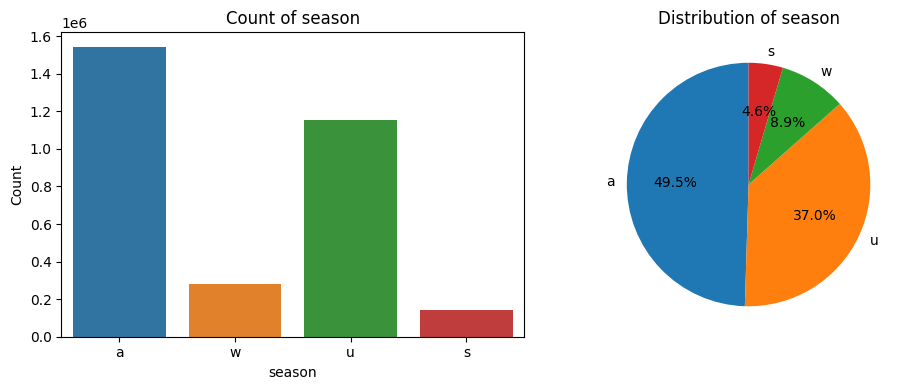

In [16]:
for i in range(len(cat_cols)):
  fig, axes = plt.subplots(1, 2, figsize=(10, 4))
  # Create a count plot
  sns.countplot(data=train, x=cat_cols[i], ax=axes[0])
  axes[0].set_title(f'Count of {cat_cols[i]}')
  axes[0].set_xlabel(cat_cols[i])
  axes[0].set_ylabel('Count')

  # Create a pie plot
  value_counts = train[cat_cols[i]].value_counts()
  axes[1].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
  axes[1].set_title(f'Distribution of {cat_cols[i]}')

  plt.tight_layout()
  plt.show()

**Correlation Analysis**

<Axes: >

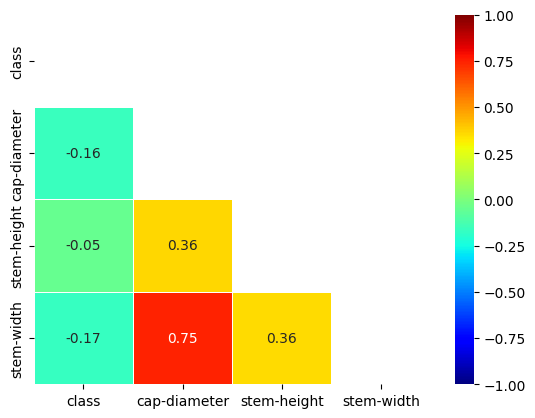

In [17]:
numeric_df = train.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, annot=True,  fmt='.2f', cmap='jet', linewidths=0.5)

**Outlier Detection**

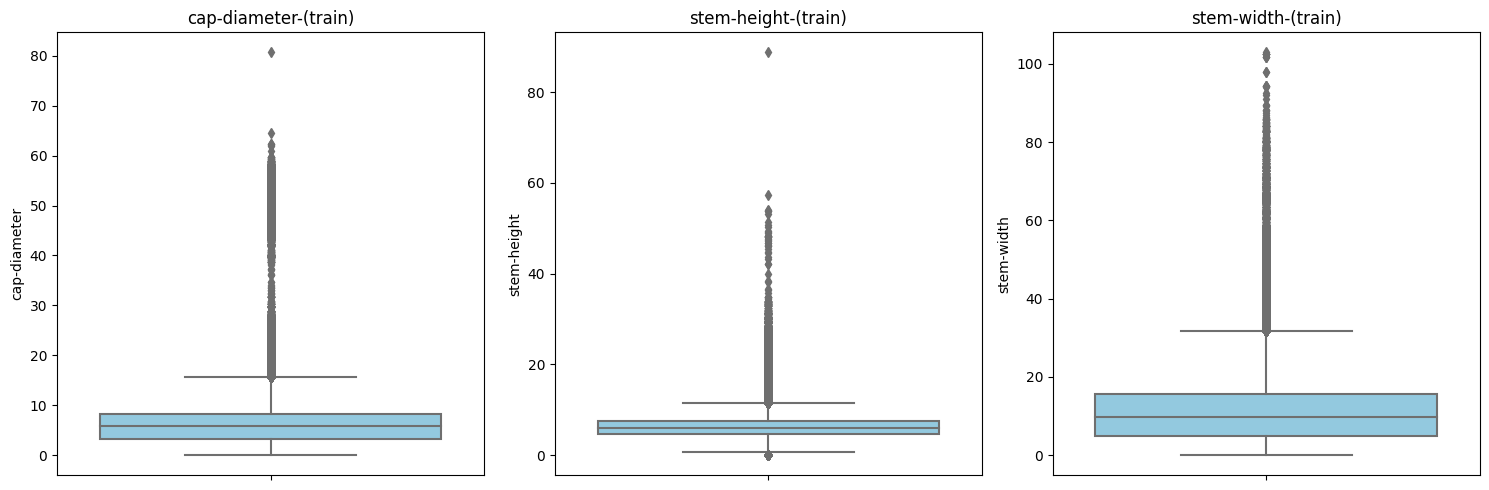

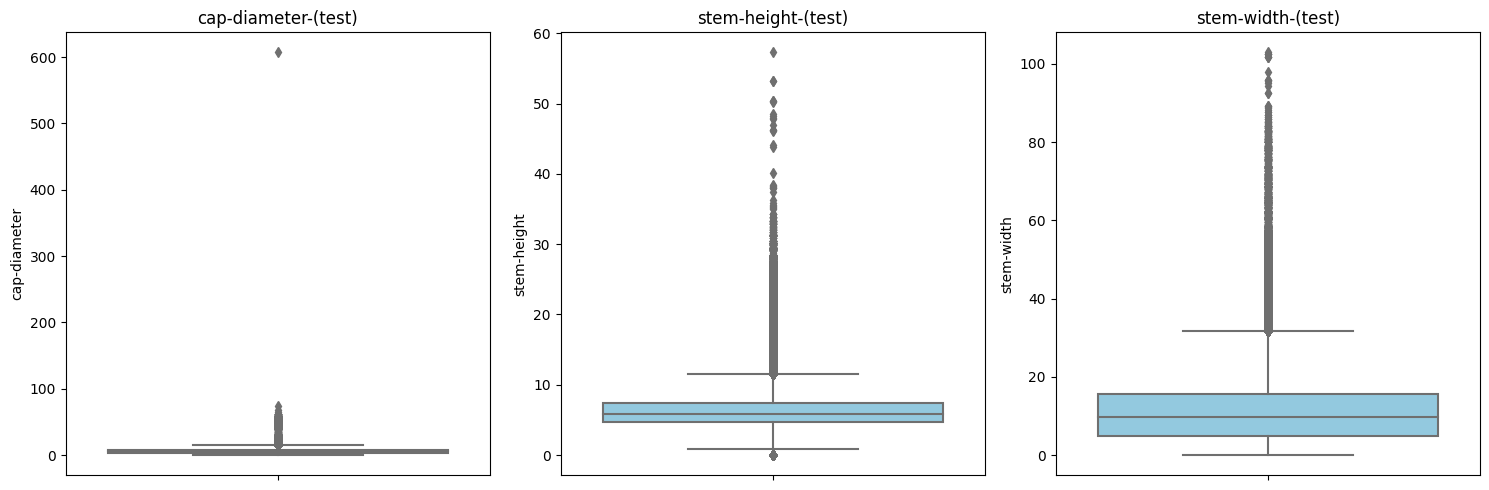

In [18]:
# Create subplots to train data
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()
for idx, column in enumerate(num_cols):
  sns.boxplot(data=train, y=num_cols[idx], ax=axes[idx], color='skyblue')
  axes[idx].set_title(f'{column}-(train)')
  axes[idx].set_xlabel('')

for i in range(idx + 1, len(axes)):
  fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Create subplots to test data
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()
for idx, column in enumerate(num_cols):
  sns.boxplot(data=test, y=num_cols[idx], ax=axes[idx], color='skyblue')
  axes[idx].set_title(f'{column}-(test)')
  axes[idx].set_xlabel('')


for i in range(idx + 1, len(axes)):
  fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [19]:
# Define the pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=3)),
    ('QTrans', QuantileTransformer(output_distribution='normal'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(transformers=[ ('num', numeric_transformer, num_cols),
                                                ('cat', categorical_transformer, cat_cols)])

# Fit and transform the data
X = preprocessor.fit_transform(X)
test = preprocessor.transform(test)

# Display the preprocessed DataFrame
print(X.shape)
print(test.shape)

(3116945, 20)
(2077964, 20)


In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=42, stratify=y)

print(X_train.shape)

(2493556, 20)


In [21]:
from sklearn.metrics import matthews_corrcoef

def mcc_metric(y_pred, dmatrix):
    y_true = dmatrix.get_label()
    y_pred = (y_pred > 0.5).astype(int) 
    mcc = matthews_corrcoef(y_true, y_pred)
    return 'mcc', mcc

In [22]:
model = XGBClassifier(                                      
    colsample_bytree=0.6,      
    max_depth=17,             
    min_child_weight=7,                
    random_state=42,                 
    n_estimators=200, 
    learning_rate = 0.07,
    gamma = 0,
    subsample = 0.8,
    reg_alpha = 0.005,
    reg_lambda = 1,            
    )



In [23]:
XGB = model.fit(
    X_train, 
    y_train) 
    #eval_set=[(X_test, y_test)],
    #eval_metric=mcc_metric)

y_pred = XGB.predict(X_test)
score = matthews_corrcoef(y_test, y_pred)
print('MCC:', score)

MCC: 0.984775335751086


In [24]:
test_pred_prob = XGB.predict(test)
test_pred_binary = (test_pred_prob > 0.5).astype(int)
test_pred_class = le.inverse_transform(test_pred_prob)
sub['class']= test_pred_class
sub.to_csv('submission.csv', index = False)
pd.read_csv('submission.csv')

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e
...,...,...
2077959,5194904,p
2077960,5194905,p
2077961,5194906,p
2077962,5194907,e
